The *BRISK* (Binary Robust Invariant Scalable Keypoints) descriptor has a predefined
sampling pattern as compared to `BRIEF` or `ORB`.
Pixels are sampled over concentric rings. For each sampling point, a small patch
is considered around it. Before starting the algorithm, the patch is smoothed
using gaussian smoothing.

Two types of pairs are used for sampling, short and long pairs.
Short pairs are those where the distance is below a set threshold distmax while the
long pairs have distance above distmin. Long pairs are used for orientation and
short pairs are used for calculating the descriptor by comparing intensities.

BRISK achieves rotation invariance by trying the measure orientation of the keypoint
and rotating the sampling pattern by that orientation. This is done by first
calculating the local gradient `g(pi,pj)` between sampling pair `(pi,pj)` where
`I(pj, pj)` is the smoothed intensity after applying gaussian smoothing.

`g(pi, pj) = (pi - pj) . I(pj, j) -I(pj, j)pj - pi2`

All local gradients between long pairs and then summed and the `arctangent(gy/gx)`
between `y` and `x` components of the sum is taken as the angle of the keypoint.
Now, we only need to rotate the short pairs by that angle to help the descriptor
become more invariant to rotation.
The descriptor is built using intensity comparisons. For each short pair if the
first point has greater intensity than the second, then 1 is written else 0 is
written to the corresponding bit of the descriptor.

## Example

Let us take a look at a simple example where the BRISK descriptor is used to
match two images where one has been translated by `(50, 40)` pixels and then
rotated by an angle of 75 degrees. We will use the `lighthouse` image from the
 [TestImages](https://github.com/timholy/TestImages.jl) package for this example.

First, let us create the two images we will match using BRISK.

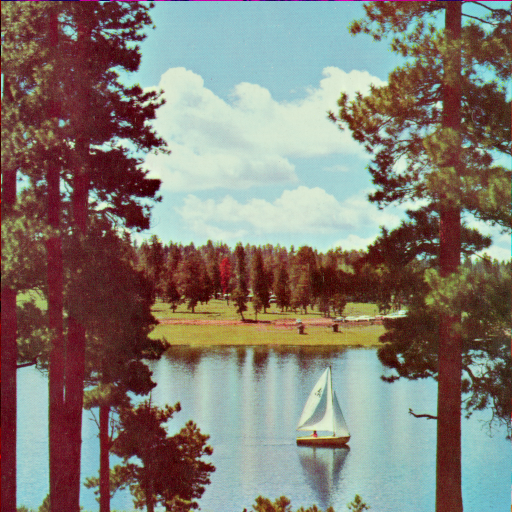

In [1]:
using ImageFeatures, TestImages, Images, ImageDraw, CoordinateTransformations, Rotations
using MosaicViews

img = testimage("lake_color")

Original Image

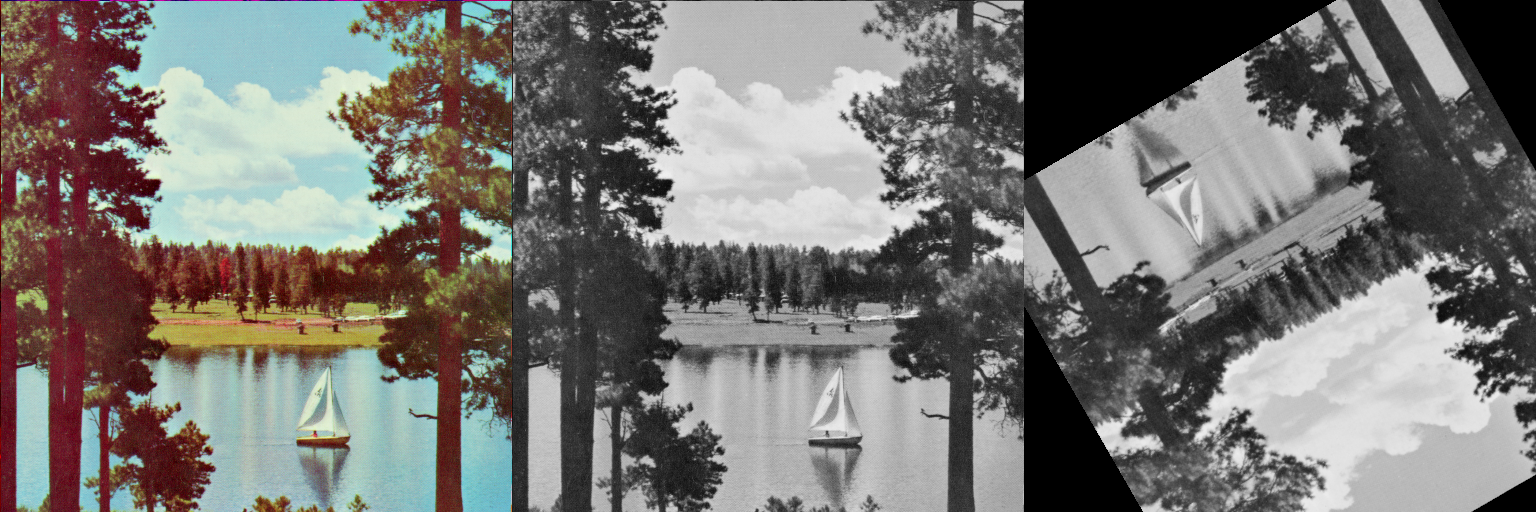

In [2]:
img1 = Gray.(img)
rot = recenter(RotMatrix(5pi/6), [size(img1)...] .÷ 2)  # a rotation around the center
tform = rot ∘ Translation(-50, -40)
img2 = warp(img1, tform, axes(img1))
mosaicview(img, img1, img2; nrow=1)

To calculate the descriptors, we first need to get the keypoints. For this
tutorial, we will use the FAST corners to generate keypoints (see `fastcorners`).

In [3]:
features_1 = Features(fastcorners(img1, 12, 0.35))
features_2 = Features(fastcorners(img2, 12, 0.35))

292-element Vector{Feature}:
 Feature(CartesianIndex(208, 1), 0.0, 0.0)
 Feature(CartesianIndex(209, 1), 0.0, 0.0)
 Feature(CartesianIndex(209, 2), 0.0, 0.0)
 Feature(CartesianIndex(210, 2), 0.0, 0.0)
 Feature(CartesianIndex(276, 31), 0.0, 0.0)
 Feature(CartesianIndex(317, 35), 0.0, 0.0)
 Feature(CartesianIndex(318, 35), 0.0, 0.0)
 Feature(CartesianIndex(317, 36), 0.0, 0.0)
 Feature(CartesianIndex(306, 48), 0.0, 0.0)
 Feature(CartesianIndex(313, 53), 0.0, 0.0)
 ⋮
 Feature(CartesianIndex(452, 510), 0.0, 0.0)
 Feature(CartesianIndex(474, 510), 0.0, 0.0)
 Feature(CartesianIndex(475, 510), 0.0, 0.0)
 Feature(CartesianIndex(311, 511), 0.0, 0.0)
 Feature(CartesianIndex(474, 511), 0.0, 0.0)
 Feature(CartesianIndex(475, 511), 0.0, 0.0)
 Feature(CartesianIndex(310, 512), 0.0, 0.0)
 Feature(CartesianIndex(311, 512), 0.0, 0.0)
 Feature(CartesianIndex(474, 512), 0.0, 0.0)

To create the BRISK descriptor, we first need to define the parameters by
calling the `BRISK` constructor.

In [4]:
brisk_params = BRISK()

BRISK(0.25, 4, 1.0, Vector{Tuple{Float16, Float16}}[[(0.0, 0.0), (0.0, 2.465), (1.449, 1.994), (2.344, 0.7617), (2.344, -0.7617), (1.449, -1.994), (0.0, -2.465), (-1.449, -1.994), (-2.344, -0.7617), (-2.344, 0.7617)  …  (0.0, -9.18), (-2.836, -8.734), (-5.395, -7.426), (-7.426, -5.395), (-8.734, -2.836), (-9.18, -0.0), (-8.734, 2.836), (-7.426, 5.395), (-5.395, 7.426), (-2.836, 8.734)], [(0.0, 0.0), (0.01512, 2.465), (1.461, 1.985), (2.35, 0.7476), (2.34, -0.776), (1.437, -2.004), (-0.01512, -2.465), (-1.461, -1.985), (-2.35, -0.7476), (-2.34, 0.776)  …  (-0.05634, -9.18), (-2.89, -8.71), (-5.44, -7.395), (-7.46, -5.35), (-8.75, -2.783), (-9.18, 0.05634), (-8.71, 2.89), (-7.395, 5.44), (-5.35, 7.46), (-2.783, 8.75)], [(0.0, 0.0), (0.03024, 2.465), (1.474, 1.977), (2.354, 0.733), (2.334, -0.7905), (1.424, -2.012), (-0.03024, -2.465), (-1.474, -1.977), (-2.354, -0.733), (-2.334, 0.7905)  …  (-0.1127, -9.18), (-2.943, -8.695), (-5.49, -7.36), (-7.492, -5.305), (-8.766, -2.729), (-9.18, 0.

Now pass the image with the keypoints and the parameters to the
`create_descriptor` function.

In [5]:
desc_1, ret_features_1 = create_descriptor(img1, features_1, brisk_params)
desc_2, ret_features_2 = create_descriptor(img2, features_2, brisk_params)

(BitVector[[1, 1, 1, 1, 1, 1, 1, 1, 0, 0  …  1, 1, 1, 1, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, 0, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [0, 0, 1, 0, 0, 0, 0, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0  …  0, 1, 0, 1, 0, 1, 1, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 1, 1  …  1, 0, 0, 0, 0, 0, 0, 0, 1, 1], [1, 1, 0, 1, 1, 1, 1, 1, 1, 1  …  0, 0, 0, 0, 0, 0, 1, 1, 0, 0], [0, 0, 1, 0, 1, 1, 0, 1, 1, 1  …  1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 1, 0, 1, 1, 1  …  0, 0, 0, 0, 0, 0, 0, 1, 0, 0]  …  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 0, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 1, 0, 1, 1, 1  …  0, 0, 0, 0, 1, 1, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1, 0, 1, 1, 1  …  0, 0, 0, 0, 0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0, 1, 1, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 1, 0, 1, 1, 1  …  0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0

The obtained descriptors can be used to find the matches between the two
images using the `match_keypoints` function.

In [6]:
matches = match_keypoints(Keypoints(ret_features_1), Keypoints(ret_features_2), desc_1, desc_2, 0.1)

64-element Vector{Vector{CartesianIndex{2}}}:
 [CartesianIndex(372, 470), CartesianIndex(313, 53)]
 [CartesianIndex(367, 470), CartesianIndex(317, 55)]
 [CartesianIndex(418, 430), CartesianIndex(253, 63)]
 [CartesianIndex(225, 494), CartesianIndex(452, 106)]
 [CartesianIndex(379, 398), CartesianIndex(270, 112)]
 [CartesianIndex(258, 434), CartesianIndex(393, 141)]
 [CartesianIndex(257, 435), CartesianIndex(394, 141)]
 [CartesianIndex(258, 419), CartesianIndex(386, 154)]
 [CartesianIndex(432, 315), CartesianIndex(183, 157)]
 [CartesianIndex(297, 393), CartesianIndex(339, 157)]
 ⋮
 [CartesianIndex(98, 135), CartesianIndex(382, 480)]
 [CartesianIndex(98, 134), CartesianIndex(382, 481)]
 [CartesianIndex(154, 96), CartesianIndex(314, 486)]
 [CartesianIndex(154, 93), CartesianIndex(313, 488)]
 [CartesianIndex(154, 92), CartesianIndex(312, 489)]
 [CartesianIndex(115, 114), CartesianIndex(357, 489)]
 [CartesianIndex(146, 92), CartesianIndex(319, 494)]
 [CartesianIndex(177, 72), CartesianIndex(

We can use the [ImageDraw.jl](https://github.com/JuliaImages/ImageDraw.jl) package to view the results.

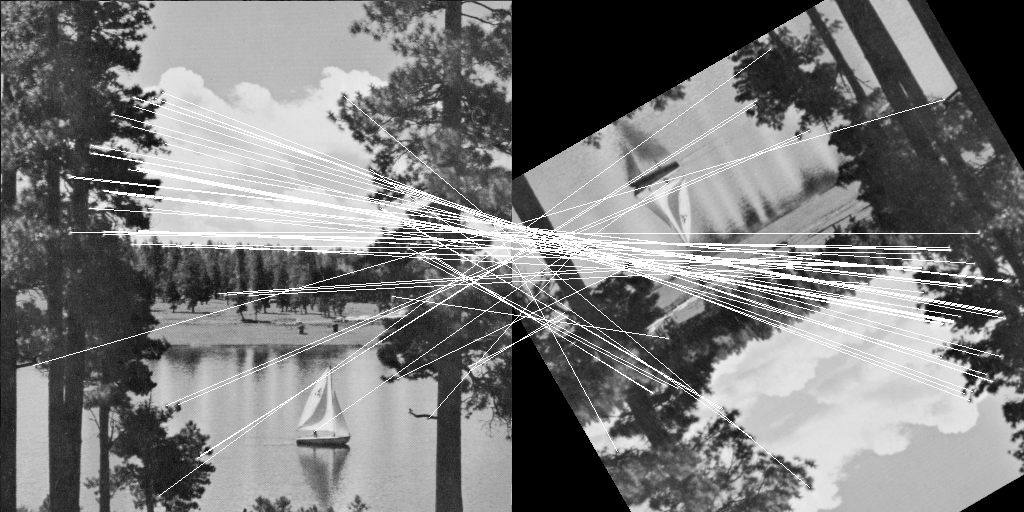

In [7]:
grid = hcat(img1, img2)
offset = CartesianIndex(0, size(img1, 2))
map(m -> draw!(grid, LineSegment(m[1], m[2] + offset)), matches)
grid

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*